In [1]:
!pip install keras
!pip install tensorflow
!pip install -q -U keras-tuner
import keras_tuner as kt
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

In [2]:
from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
# from keras.optimizers import adam_v2 # from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
vocabulary = dict()
# loading pretrained word embeddings corpura
EMBEDDING_FILE = 'glove.6B.100d.txt'

In [6]:
df = pd.read_csv("quora_duplicate_questions.tsv", sep='\t')


In [7]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)


In [8]:
#The dropna() method is used to drop/remove missing values from a DataFrame.
df.info()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage:

In [9]:
train_df.dropna(inplace=True)

In [10]:
test_df.dropna(inplace=True)

In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
train_df = train_df.iloc[: , 1:]
train_df.head()


,qid1,qid2,question1,question2,is_duplicate
316519,441587,80157,How should I prepare to get a job as a program...,How do I get a job in startup companies in India?,0
328265,454777,454778,The NPV rule says to go for the project that h...,What is adjusted net present value approach?,0
148707,234403,234404,What if god was an engineer?,What is God like?,0
366989,37232,497250,How can I be a better husband?,How can I be a better wife?,0
349533,420062,478198,Where is the best home appliance service cente...,Which one is the best home appliances service ...,1


In [13]:

test_df = test_df.iloc[: , 1:]
test_df.head()

,qid1,qid2,question1,question2,is_duplicate
8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [14]:
stops = set(stopwords.words('english'))

def question_preprocessing(text):
    ''' Pre process and convert questions to a list of words '''
    text = str(text)
    text = text.lower()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [15]:

file_path = 'glove.6B.100d.txt'
vocab_size = 40000
embedding_dim = 100
max_seq_length = 20
questions_cols = ['question1', 'question2']
googleword2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)


In [16]:
def question_to_num(word2vec):
    inverse_vocabulary = ['<unk>']
    vocabulary = {}  # Define the vocabulary dictionary
    questions_cols = ['question1', 'question2']

    # Iterate over the questions only of both training and test datasets
    for dataset in [train_df, test_df]:
        for index, row in dataset.iterrows():
            # Iterate through the text of both questions of the row
            for question in questions_cols:
                q2n = []  # q2n -> question numbers representation
                for word in question_preprocessing(row[question]):
                    # Check for unwanted words
                    if word in stops and word not in word2vec.key_to_index:
                        continue
                    if word not in vocabulary:
                        vocabulary[word] = len(inverse_vocabulary)
                        q2n.append(len(inverse_vocabulary))
                        inverse_vocabulary.append(word)
                    else:
                        q2n.append(vocabulary[word])

                # Replace questions as word to question as number representation
                dataset.at[index, question] = q2n

    embedding_dim = 100
    embeddings = np.zeros((len(vocabulary) + 1, embedding_dim))  # Initialize the embedding matrix

    # Build the embedding matrix
    for word, index in vocabulary.items():
        if word in word2vec.key_to_index:
            embeddings[index] = word2vec.get_vector(word)

    del word2vec
    return embeddings

In [17]:
embeddings=question_to_num(googleword2vec)

In [18]:
test_df.head()

,qid1,qid2,question1,question2,is_duplicate
8067,15738,15739,"[1, 15, 3, 1685, 3037, 1866, 20, 11, 6740]","[1, 15, 3, 1685, 3037, 1866, 20, 11, 879]",0
368101,12736,104117,"[29, 92, 127, 66, 16, 58, 291, 7474, 21, 22491...","[29, 92, 127, 344, 291, 7474, 21, 20280, 1693]",0
70497,121486,121487,"[41, 44, 361, 8689, 39, 54, 2230, 21, 7, 9721,...","[29, 44, 16, 58, 6833, 6885, 21, 53707]",0
226567,254474,258192,"[1, 15, 3, 1567, 11643, 1345, 2082]","[1, 52, 3, 1567, 201, 11643, 2082, 21, 1345]",1
73186,48103,3062,"[1, 2968, 700, 92, 5, 739, 8458, 552, 409]","[1, 2968, 44, 7, 552, 409, 2056]",1


In [19]:

max_seq_length=20
questions_cols = ['question1', 'question2']

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'input_1': X_train.question1, 'input_2': X_train.question2}
X_validation = {'': X_validation.question1, 'input_2': X_validation.question2}
X_test = {'input_1': test_df.question1, 'input_2': test_df.question2}


# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Zero padding
for dataset, side in itertools.product([X_train, X_test], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['input_1'].shape == X_train['input_2'].shape
assert len(X_train['input_1']) == len(Y_train)

 # modèle Siamese Neural Network

In [21]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

# Model variables
n_hidden = 10
gradient_clipping_norm = 1.25
#Reduce the batch size: Decreasing the batch size will require less memory during training. You can try reducing the batch_size parameter to a smaller value, such as 32 or even 16.
batch_size = 30
n_epoch = 2
embedding_dim = 100

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=True)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])


In [22]:
malstm_trained = malstm.fit([X_train['input_1'], X_train['input_2']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['input_1'], X_validation['input_2']], Y_validation))

Epoch 1/2
20258/20258 [==============================] - 3584s 177ms/step - loss: 0.1496 - accuracy: 0.7854 - val_loss: 0.1355 - val_accuracy: 0.8108
Epoch 2/2
20258/20258 [==============================] - 3439s 170ms/step - loss: 0.1137 - accuracy: 0.8436 - val_loss: 0.1297 - val_accuracy: 0.8197


NameError: name 'time' is not defined

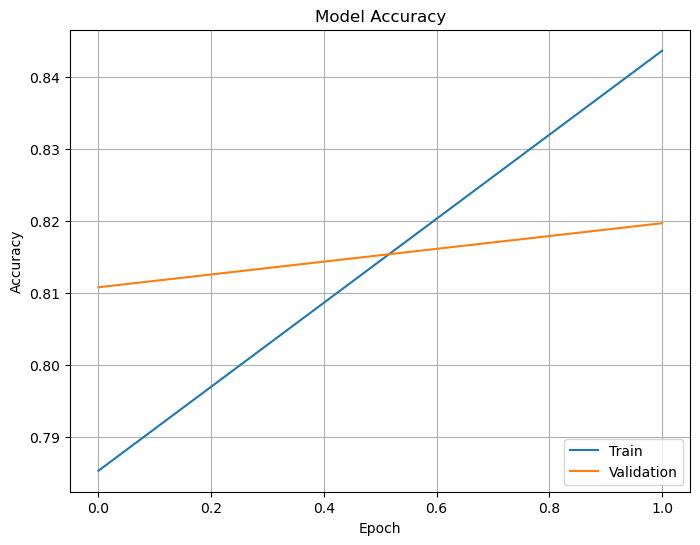

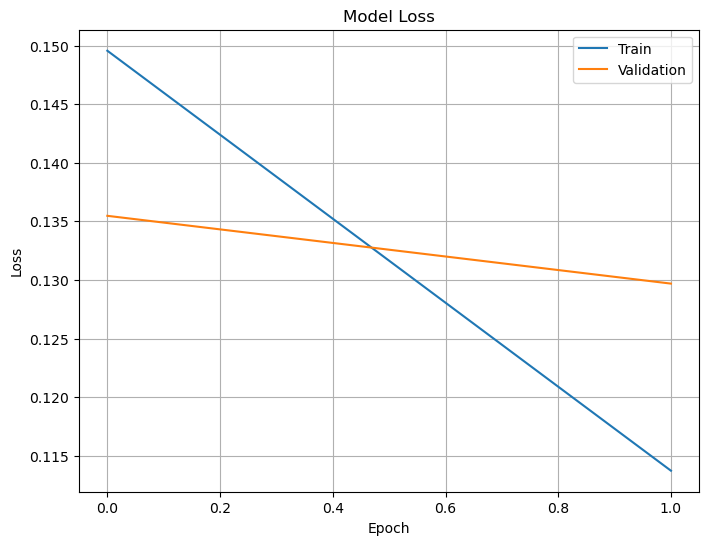

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(malstm_trained.history['accuracy'], label='Train')
plt.plot(malstm_trained.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(malstm_trained.history['loss'], label='Train')
plt.plot(malstm_trained.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [24]:
for dataset, side in itertools.product([X_test], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
Y_test=test_df['is_duplicate'].values
res=malstm.predict(X_test)
print(res)


5054/5054 [==============================] - 22s 4ms/step
[[0.28621128]
 [0.12425502]
 [0.02942873]
 ...
 [0.9251378 ]
 [0.02148532]
 [0.00721667]]


In [25]:
a=[]
for i in res:
    if i>0.5:
        a.append(1)
    else:
        a.append(0)

In [33]:
test_df.head()

,qid1,qid2,question1,question2,is_duplicate
8067,15738,15739,"[1, 15, 3, 1685, 3037, 1866, 20, 11, 6740]","[1, 15, 3, 1685, 3037, 1866, 20, 11, 879]",0
368101,12736,104117,"[29, 92, 127, 66, 16, 58, 291, 7474, 21, 22491...","[29, 92, 127, 344, 291, 7474, 21, 20280, 1693]",0
70497,121486,121487,"[41, 44, 361, 8689, 39, 54, 2230, 21, 7, 9721,...","[29, 44, 16, 58, 6833, 6885, 21, 53707]",0
226567,254474,258192,"[1, 15, 3, 1567, 11643, 1345, 2082]","[1, 52, 3, 1567, 201, 11643, 2082, 21, 1345]",1
73186,48103,3062,"[1, 2968, 700, 92, 5, 739, 8458, 552, 409]","[1, 2968, 44, 7, 552, 409, 2056]",1
